In [1]:

import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import torch
import math
import json

""" import copy
import networkx as nx
from tqdm import tqdm
from PIL import Image
from crp.image import imgify, vis_opaque_img, plot_grid
from torch.utils.data import DataLoader
from crp.concepts import ChannelConcept
import time
from expbasics.nmf import sample_cavs, nmf, nearest_neighbors, vis_nearest_neighbors, load_cavs, sample_relevance_cavs, sample_bbox_cavs, sample_all_relevances_cavs
from expbasics.helper import get_attributions, get_model_etc, to_name
from expbasics.visualizations import sum_it, data_iterations
from expbasics.dim_reduction import visualize_dr, get_dr_methods, clean_centroids, centroid_distances
from expbasics.network import load_model, train_network, accuracy_per_class
from expbasics.biased_noisy_dataset import get_biased_loader, BiasedNoisyDataset
from expbasics.test_dataset import TestDataset
from expbasics.crp_attribution import CRPAttribution
from expbasics.causal_discovery import remove_empty, causal_discovery
from expbasics.ground_truth_measures import GroundTruthMeasures """

%reload_ext autoreload
%autoreload 2

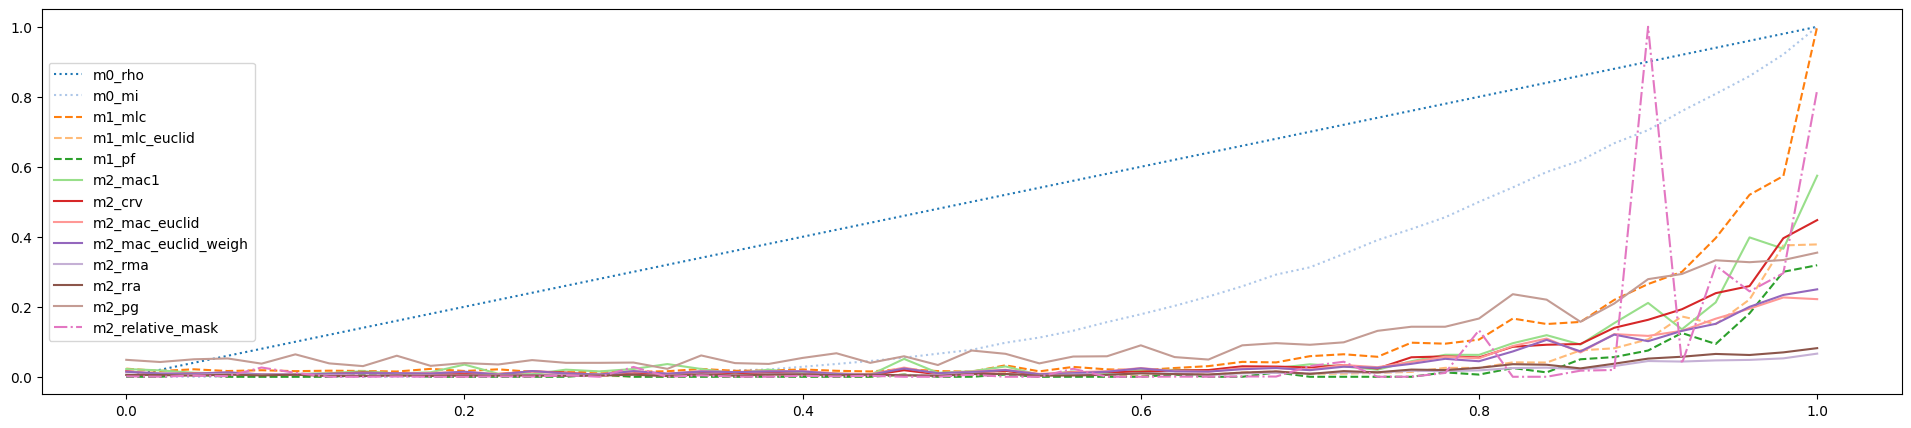

In [25]:
with open("over_rho.json", "r") as f:
    all_vals = json.load(f)
biases = []
mlen = len(all_vals["0.0"].keys())
colors = matplotlib.cm.tab20(np.linspace(0, 1, max(20,mlen)))#.gist_rainbow(np.linspace(0, 1, mlen))  # type: ignore
vals = np.zeros((mlen,51))
labels = list(all_vals["0.0"].keys())
for bi, b in enumerate(all_vals.keys()):
    biases.append(float(b))
    for i, (k, item) in enumerate(all_vals[b].items()):
        vals[i, bi] = item
biases = np.array(biases)
plt.figure(figsize=(24,5))
for i, l in enumerate(labels):
    linestyle = "dashed" if l.startswith("m1") else "solid"
    linestyle = "dotted" if l.startswith("m0") else linestyle
    linestyle = "dashdot" if l == "m2_relative_mask" else linestyle
    item = vals[i,:]
    if l == "m1_mlc":# or l == "m2_mac1":
        item = vals[i,:] / (vals[i,:].max() + 1e-10)
    if l == "m2_relative_mask":# or l == "m2_mac1":
        item = vals[i,:] / (vals[i,:].max() + 1e-10)
        #item = np.where(vals[i,:] < 1, vals[i,:], 1) 
        #item = np.where(item > 0, item, 0) 
    plt.plot(biases,item,label=l, c=colors[i],linestyle=linestyle)
plt.legend(loc="center left")

/tmp/ipykernel_29928/489168792.py:24: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(biases,item,label=label, c=colors[i])


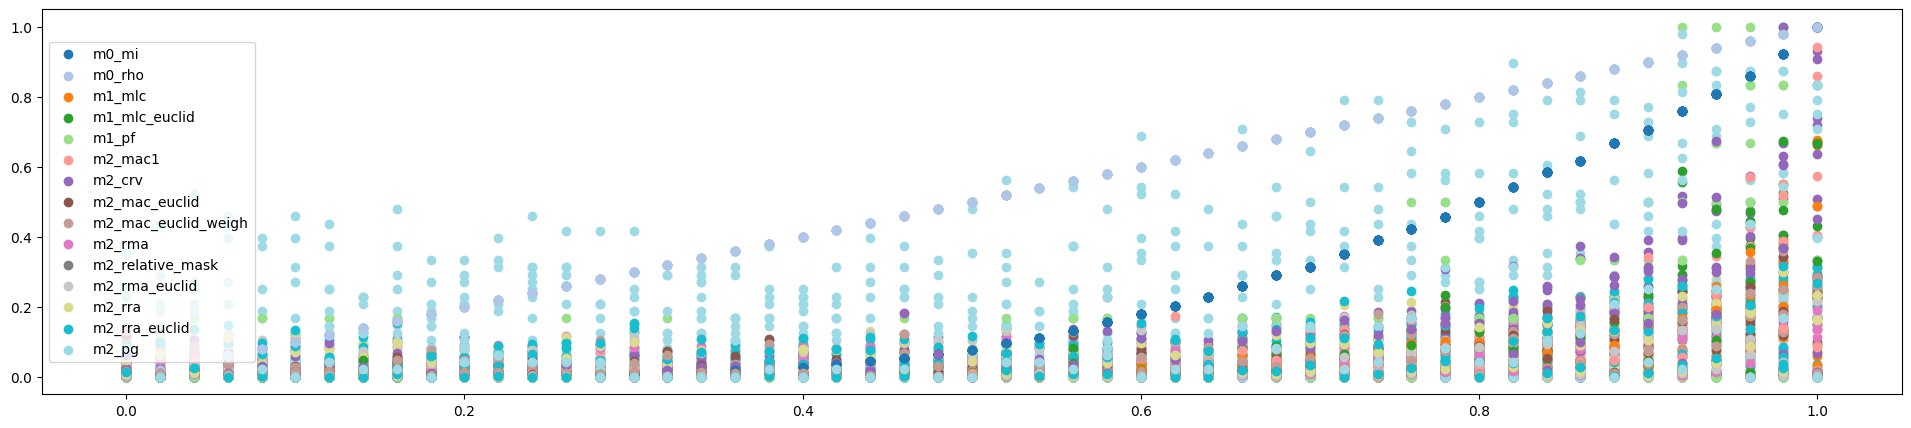

In [3]:
with open("models_values.json", "r") as f:
    all_vals = json.load(f)
biases = []
mlen = len(all_vals["0.0"]["0"].keys())
colors = matplotlib.cm.tab20(np.linspace(0, 1, mlen))#.gist_rainbow(np.linspace(0, 1, mlen))  # type: ignore
vals = np.zeros((mlen,16,51))
labels = list(all_vals["0.0"]["0"].keys())
for bi, b in enumerate(all_vals.keys()):
    biases.append(float(b))
    for num_it in all_vals[b].keys():
        for i, (k, item) in enumerate(all_vals[b][num_it].items()):
            vals[i,int(num_it), bi] = item
biases = np.array(biases)
plt.figure(figsize=(24,5))
for n in range(16):
    for i, l in enumerate(labels):
        if "cosine" not in l:
            item = vals[i,n,:]
            if "euclid" in l:
                item = vals[i,n,:] / 2#(vals[i,:].max() + 1e-10)
            if  l in ["m1_mlc","m1_pf", "m2_crv", "m2_mac1", "m2_rma_val"]:
                item = vals[i,n,:] / (vals[i,:].max() + 1e-10)
            label = l if n == 0 else ""
            plt.scatter(biases,item,label=label, c=colors[i])
plt.legend(loc="center left")

In [9]:
math.isnan(all_vals["0.0"]["m2_relative_mask"])

True

In [17]:
#iterations * rhos * images * types
16*51* 10 * 2

8160